In [1]:
# Stardard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# K-Means
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
# DBSCAN/OPTICS
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn import cluster
# Scalar data
from sklearn.preprocessing import StandardScaler
# PCA
from sklearn.decomposition import PCA
# Hierarchy
from scipy.cluster.hierarchy import linkage,dendrogram

# Task 1 - The Data

### Data Reference: https://archive.ics.uci.edu/dataset/484/travel+reviews

In [2]:
df = pd.read_csv("tripadvisor_review.csv")
df

,User ID,Category 1,Category 2,Category 3,Category 4,Category 5,Category 6,Category 7,Category 8,Category 9,Category 10
0,User 1,0.93,1.80,2.29,0.62,0.80,2.42,3.19,2.79,1.82,2.42
1,User 2,1.02,2.20,2.66,0.64,1.42,3.18,3.21,2.63,1.86,2.32
2,User 3,1.22,0.80,0.54,0.53,0.24,1.54,3.18,2.80,1.31,2.50
3,User 4,0.45,1.80,0.29,0.57,0.46,1.52,3.18,2.96,1.57,2.86
4,User 5,0.51,1.20,1.18,0.57,1.54,2.02,3.18,2.78,1.18,2.54
...,...,...,...,...,...,...,...,...,...,...,...
975,User 976,0.74,1.12,0.30,0.53,0.88,1.38,3.17,2.78,0.99,3.20
976,User 977,1.25,0.92,1.12,0.38,0.78,1.68,3.18,2.79,1.34,2.80
977,User 978,0.61,1.32,0.67,0.43,1.30,1.78,3.17,2.81,1.34,3.02
978,User 979,0.93,0.20,0.13,0.43,0.30,0.40,3.18,2.98,1.12,2.46


### Features description
- Category 1: Average user feedback on art galleries
- Category 2: Average user feedback on dance clubs
- Category 3: Average user feedback on juice bars
- Category 4: Average user feedback on restaurants
- Category 5: Average user feedback on museums
- Category 6: Average user feedback on resorts
- Category 7: Average user feedback on parks/picnic spots
- Category 8: Average user feedback on beaches
- Category 9: Average user feedback on theaters
- Category 10: Average user feedback on religious insitutions

- Their unit is rated in a scale from 0 to 4 (Excellent (4), Very Good (3), Average (2), Poor (1), and Terrible (0))

### It is suitable for clustering different profiles of tourists because:
- The ratings give us a straightforward way to measure what users think. Ans because it’s a numerical scale, it works perfectly with different clustering methods.
- It brings together a wide range of opinions from travelers about different spots, so it gives a solid picture of what users prefer.
- The dataset shows exactly what tourists enjoy or don’t, which makes it super helpful for grouping them into profiles.

# Task 2 & 3 - IDA and Preprocessing

In [3]:
df.shape

(980, 11)

- The dataset contains 980 rows and 11 columns
- But there is a column that is no a real feature that is the 'User ID', so we are going to drop it.
- And Since the categories aren't named, we have to rename according to the documentation their category because it might be confusing.

In [4]:
real_names = {"Category 1":"art_galleries","Category 2":"dance_clubs","Category 3":"juice_bars","Category 4":"restaurants","Category 5":"museums","Category 6":"resorts","Category 7":"parks","Category 8":"beaches","Category 9":"theaters","Category 10":"religious_institutions"}
df = df.rename(columns=real_names)
df = df.drop(columns="User ID")
df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 980 entries, 0 to 979
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   art_galleries           980 non-null    float64
 1   dance_clubs             980 non-null    float64
 2   juice_bars              980 non-null    float64
 3   restaurants             980 non-null    float64
 4   museums                 980 non-null    float64
 5   resorts                 980 non-null    float64
 6   parks                   980 non-null    float64
 7   beaches                 980 non-null    float64
 8   theaters                980 non-null    float64
 9   religious_institutions  980 non-null    float64
dtypes: float64(10)
memory usage: 76.7 KB


art_galleries             0
dance_clubs               0
juice_bars                0
restaurants               0
museums                   0
resorts                   0
parks                     0
beaches                   0
theaters                  0
religious_institutions    0
dtype: int64

- All the columns are with a numeric unit so we don't have to worry about any convertion.
- And there is no missing values we have to worry about.

# Task 4 – EDA: Statistical Properties

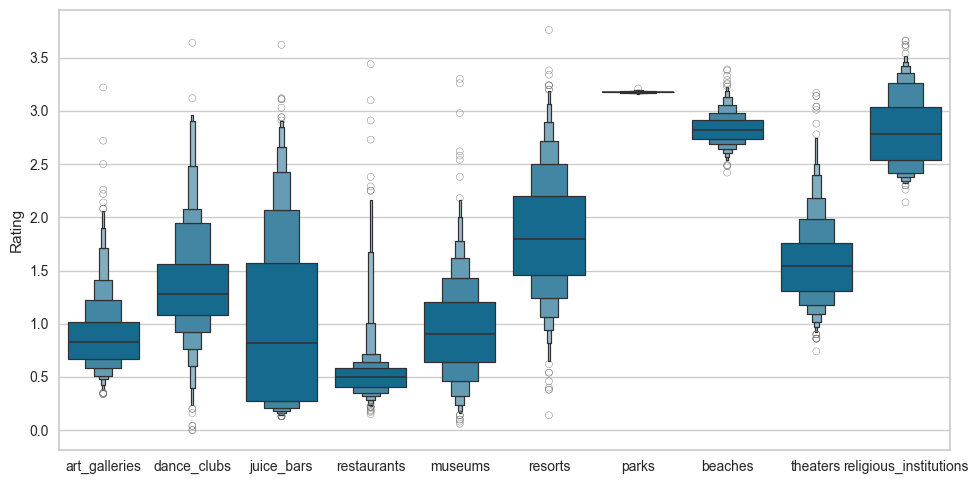

In [5]:
# Statistics analysis
df_melted = pd.melt(df,value_vars=['art_galleries','dance_clubs','juice_bars','restaurants','museums','resorts','parks','beaches','theaters','religious_institutions'])
fig = plt.figure(figsize= (10,5))
boxplot = sns.boxenplot(x='variable',y='value',data=df_melted)
boxplot.set_xlabel("")
boxplot.set_ylabel("Rating")
fig.tight_layout()

#### Statistics
- **juice_bars** has the widest spread, ranging around 0.3 to 1.5. This indicates a large variance
- **dance_clubs** and **theaters** also have high variability but have a more compact range compared to juice_bars
- **parks** shows an extremely narrow distribution
- **beaches** and **religious_institutions** have good mean ratings around 3.0, meaning good satisfaction
- On the other hand, it happens the opposite with **restaurants** and **art_galleries** with an average around the 0.5, terrible satisfaction

#### Outliers
- In all the categories with have a notable amount of outliers. Extreme ratings that very different of the perspective of the rest

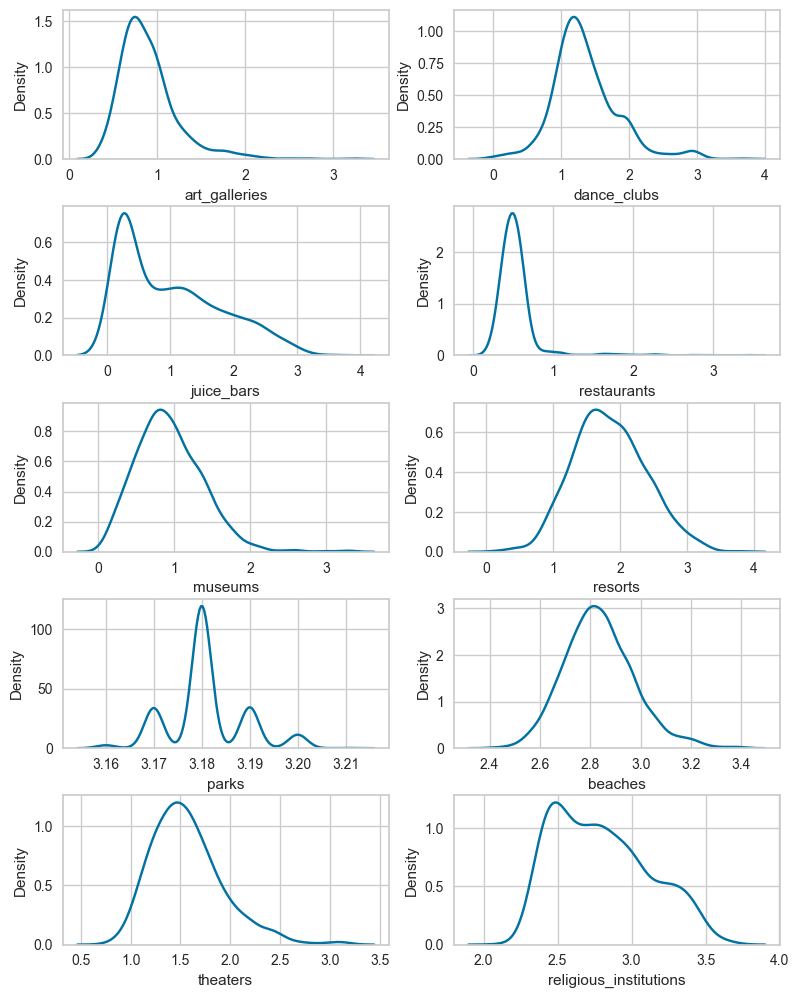

In [6]:
# Distribution analysis
df_columns = ['art_galleries','dance_clubs','juice_bars','restaurants','museums','resorts','parks','beaches','theaters','religious_institutions']
fig, axes = plt.subplots(5, 2,figsize=(8,10))
fig.tight_layout()
count = 0
for i in range(5):
    for j in range(2):
        sns.kdeplot(df[df_columns[count]],ax = axes[i,j])
        count+=1
plt.show()

#### Distributions
- From the above plots, it's observed that all the features need have some outliers in their distribution.
- The density plots reveal that most categories, like **art galleries**, **dance clubs**, **juice bars**, and **restaurants**, are right-skewed, with values clustered at lower ranges and potential outliers on the end. Categories like **resorts**, **parks**, **beaches**, and **theaters** display more symmetric normal distributions.

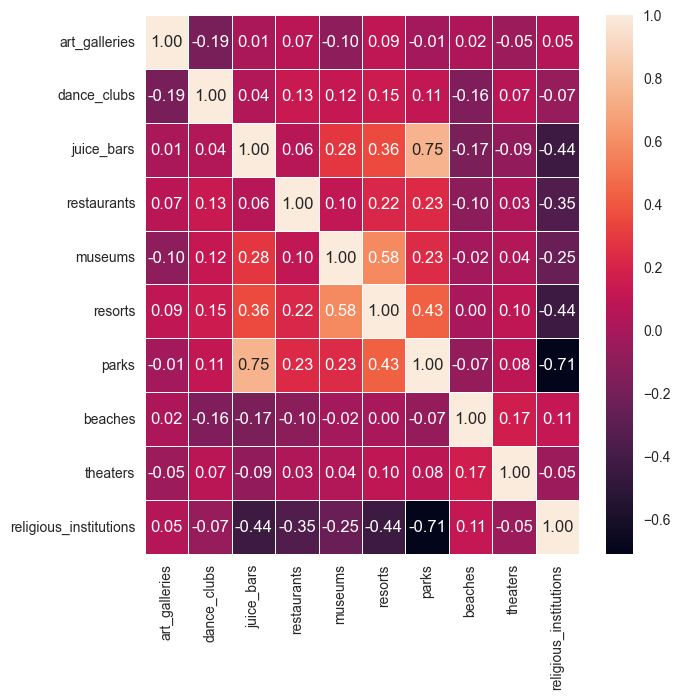

In [7]:
#Corelation analysis
plt.figure(figsize=(7,7))
sns.heatmap(df.corr(),annot=True,linewidths=0.5, fmt=".2f")
plt.show()

#### Relations
- Positive Correlations
    - The most strong positive correlation is between juice_bars and parks, these have a strong positive correlation of 0.75
    - Suggesting that people users that rate one good tend to do the same with the other.
    - Another positive relation would be the one between museums and resorts (0.58)
    - Might indicate that visitors have a profile of cultural and luxury experiences together.

- Negative Correlations
    - On the hand, we have the negative relation between praks and religious_institutions with -0.71, that could indicate us a divergence of these attributes.
    - And other relations to take of are the relations between juice_bars and restaurants with religious_institutions, -0.44 and -0.35, each one.

# Task 5 - EDA: Clustering

#### Transforming dataframe into standarized format, so that all features would be on a similar scale.

In [8]:
# Scaling the data
scaler = StandardScaler()
df_sc = scaler.fit_transform(df)
df_sc = pd.DataFrame(df_sc, index=df.index, columns=df.columns)

#### K-means

In [9]:
def getKMeans(k, n_init=20, max_iter=50):
    """
        The function returning KMeans

        param n_nit: number of times the KMeans algorithm will run with different initializations (sometimes get stuck in local optima)
        param max_iter: maximum number of iterations the algorithm will perform     
    """

    return KMeans(n_clusters = k,random_state = 1, n_init = n_init, max_iter = max_iter)

In [10]:
def sihouetteVisualizer(df, k):
    """
        The function takes adf and a Sklean clusterer to fit the Silhouette visualizer and plot it
    """
    model = SilhouetteVisualizer(k)
    model.fit(df)
    model.finalize()

In [11]:
def KMeansSihouettePlot(dataframe, k_max):
    """
        The function takes a df and the maximum k to plot.
        It calculates KMeans for different cluster size and plot their sil_scores 
    """  
    sil_scores = []

    for n in range(2, k_max):
        kmeans = getKMeans(n)
        cluster_labels = kmeans.fit_predict(dataframe)
        sil_scores.append(silhouette_score(dataframe, cluster_labels))
        plt.plot(range(2,n+1), sil_scores)
        plt.title("Silhouette Coefficient Scores")
        plt.xlabel(f"Number of k")
        plt.ylabel("Silhouette Coefficient Score")

- First we find the suitable number of k clusters with the elbow method

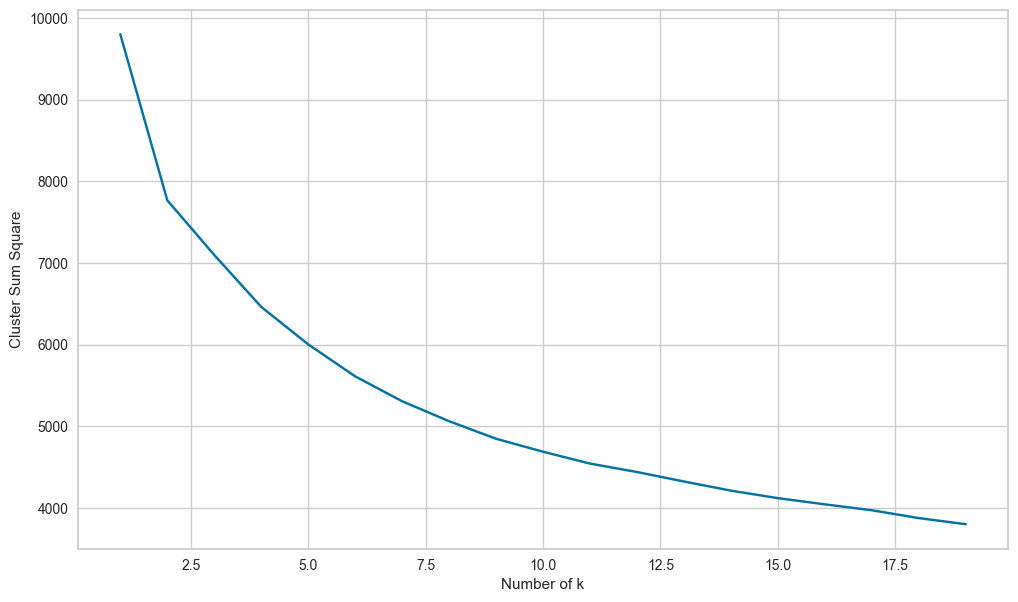

In [12]:
cluster_sum_square  = []
for i in range(1,20):
    kmeans = getKMeans(k=i)
    kmeans.fit(df_sc)
    cluster_sum_square.append(kmeans.inertia_)

#Plot to see the where is the point where the elbow is formed
plt.figure(figsize=(12,7))
plt.plot(range(1,20), cluster_sum_square)
plt.xlabel('Number of k')
plt.ylabel('Cluster Sum Square')
plt.grid(True)
plt.show()

- As we can see we have the suitable number between 2 or 4, where the rate of reduction slows and the elbows occurs.

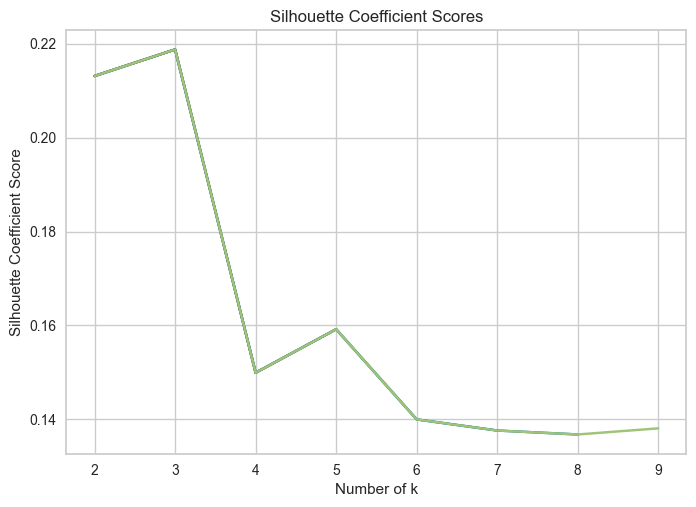

In [13]:
KMeansSihouettePlot(df_sc,10)

- From the previous plot , we can observe that at cluster size of k=3, with a coefficient arounf 0.22, it is the best option.

c:\Users\Pablo\Desktop\Mathematics and Multivariate Statistics\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


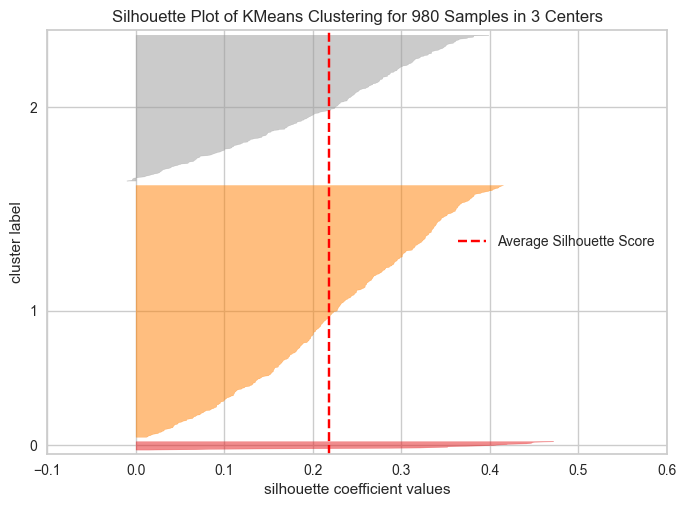

In [14]:
kmeans = getKMeans(k=3)
cluster_labels = pd.DataFrame(kmeans.fit_predict(df_sc))
sihouetteVisualizer(df_sc, kmeans)

In [15]:
print(cluster_labels.value_counts())

0
1    607
2    352
0     21
Name: count, dtype: int64


- As we can see the average sil_score is around 0.2, which is a bad signal and the clusters are not very separated
- Cluster 2 and 1 have positive values, but they don't have the best shape, indicating moderate cohesion
- And Cluster 0 only has a few samples, but it has the best sil_score among the others,probably because of the first fact.
- However, KMeans has performed bad because the average sil_core < 0.25, so there is no structure.

#### DBSCAN

In [16]:
def df_neigh(num_neighbours, eps):
    """# Fuction to create a df that contains which cluster is each row appplying DBSCAN

    Args:
        num_neighbours (int): number of k-nearest neighbors
        eps (float): distance between neighbours

    Returns:
        DataFrame: cointaining the value of each sample cluster
    """
    dbscan = DBSCAN(eps=eps,min_samples=num_neighbours, metric='euclidean')
    dbscan.fit(df_sc)
    db_cluster_neigh = pd.DataFrame(dbscan.labels_,columns=['Cluster'])
    return db_cluster_neigh

In [17]:
def plot_neigh(k):
    """Generates a plot for the evolution eps depending on the number of k

    Args:
        k (int): number of clusters
    """
    nearest_neighbors = NearestNeighbors(n_neighbors=k)
    neighbors = nearest_neighbors.fit(df_sc)
    distances, indices = neighbors.kneighbors(df_sc)
    distances = np.sort(distances[:, k-1], axis=0)

    # Plot the k-distance graph
    plt.plot(distances)
    plt.xlabel('Points sorted by distance')
    plt.ylabel(f'{k}-distance')
    plt.title('k-NN Distance Plot')
    plt.show()

- First we are going to start with 11 since it is dimensionality + 1

##### num_neighbours = 11

- First all, we can you to see the progression of the eps, so we can choose this hyperparameter wisely

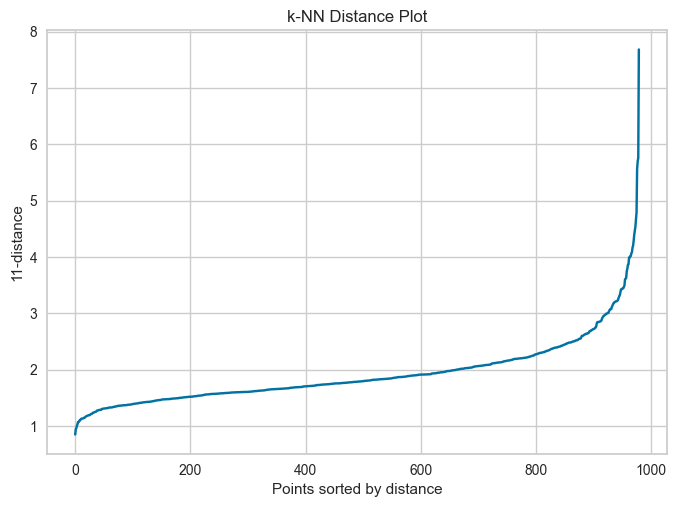

In [18]:
plot_neigh(11)
# eps around 3

In [19]:
df_aux = df_neigh(11,3)
print(df_aux.value_counts())

Cluster
 0         958
-1          22
Name: count, dtype: int64


- As we can see there is one big cluster and outliers so we are going to reduce the distance

In [20]:
df_aux = df_neigh(11,2)
print(df_aux.value_counts())

Cluster
 0         847
-1         133
Name: count, dtype: int64


- Same as last case

In [21]:
df_aux = df_neigh(11,1.5)
print(df_aux.value_counts())

Cluster
-1         510
 0         393
 2          51
 1          15
 3          11
Name: count, dtype: int64


- In this scenario we too much outliers
- So we are going to decrease min_neighbours, since few or no clusters are formed amd usually means that the density requirement is too high.

##### num_neighbours = 9

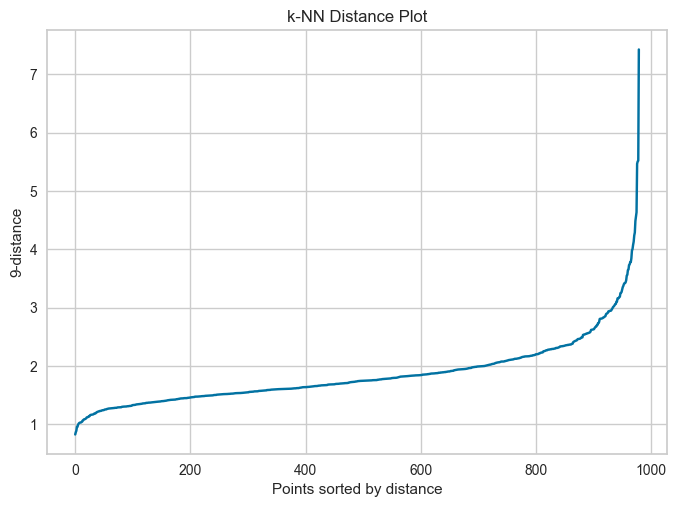

In [22]:
plot_neigh(9)
# around 2.5

In [23]:
df_aux = df_neigh(9,2.5)
print(df_aux.value_counts())

df_aux = df_neigh(9,2)
print(df_aux.value_counts())

df_aux = df_neigh(9,1.5)
print(df_aux.value_counts())

Cluster
 0         937
-1          43
Name: count, dtype: int64
Cluster
 0         858
-1         122
Name: count, dtype: int64
Cluster
-1         471
 0         410
 2          62
 1          18
 4          11
 3           8
Name: count, dtype: int64


- Still to much outliers
- So last try if this algorithm is suitable

##### num_neighbours = 5

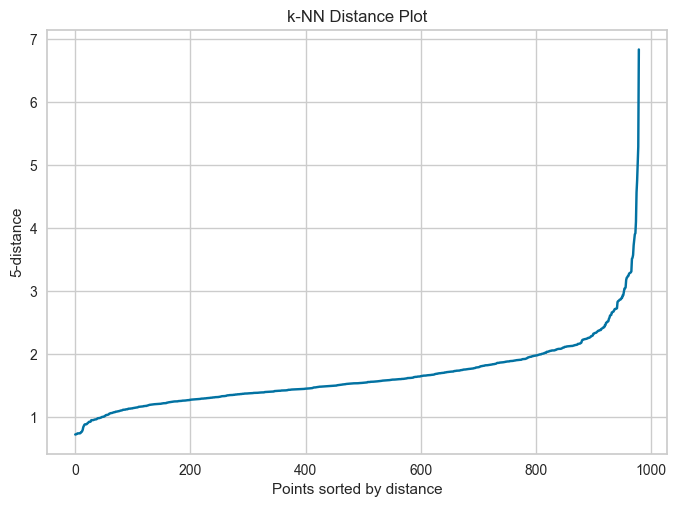

In [24]:
plot_neigh(5)
# around 2

In [25]:
df_aux = df_neigh(5,2)
print(df_aux.value_counts())

df_aux = df_neigh(5,1.5)
print(df_aux.value_counts())

df_aux = df_neigh(5,1)
print(df_aux.value_counts())

Cluster
 0         878
-1          90
 1           6
 2           6
Name: count, dtype: int64
Cluster
 0         624
-1         346
 1           5
 2           5
Name: count, dtype: int64
Cluster
-1         898
 2          17
 3          17
 1          11
 4           8
 0           7
 5           6
 6           6
 7           5
 8           5
Name: count, dtype: int64


- To conclude this algorithm is not suitable for this case.

#### SCAN

In [26]:
def df_neigh_scan(num_neighbours, eps):
    """ Fuction to create a df that contains which cluster is each row applying OPTICS

    Args:
        num_neighbours (int): number of k-nearest neighbors
        eps (float): distance between neighbours

    Returns:
        DataFrame: cointaining the value of each sample cluster
    """
    optics = OPTICS(min_samples=num_neighbours, eps=eps)
    optics_labels = optics.fit_predict(df_sc)
    optics_labels = pd.DataFrame(optics_labels)
    return optics_labels

- We test this algorithm like the previous one. But it is probably not going to work based on the previous results of DBSCAN.

##### min_samples = 11

In [27]:
optics_labels = df_neigh_scan(11,0.05)
print(optics_labels.value_counts())

0
0    980
Name: count, dtype: int64


##### min_samples = 9

In [28]:
optics_labels = df_neigh_scan(9,0.05)
print(optics_labels.value_counts())

0 
-1    944
 1     13
 2     13
 0     10
Name: count, dtype: int64


##### min_samples = 5

In [29]:
optics_labels = df_neigh_scan(5,0.05)
print(optics_labels.value_counts())

0  
-1     857
 11     17
 4      15
 8      12
 1      11
 5      11
 2       9
 13      8
 0       7
 7       7
 3       6
 9       5
 6       5
 10      5
 12      5
Name: count, dtype: int64


- Happened more or less like with DBSCAN, or either there a huge quantity of outliers or one single big cluster.
- So this algorithm as previous suspected is not suitable.

#### HAC

- First we are going to plot directly diverse linkage options to see which one suits good with the df with the distance calculted by 'eucliden', then 'cosine', and last 'manhattan'.

##### Euclidean

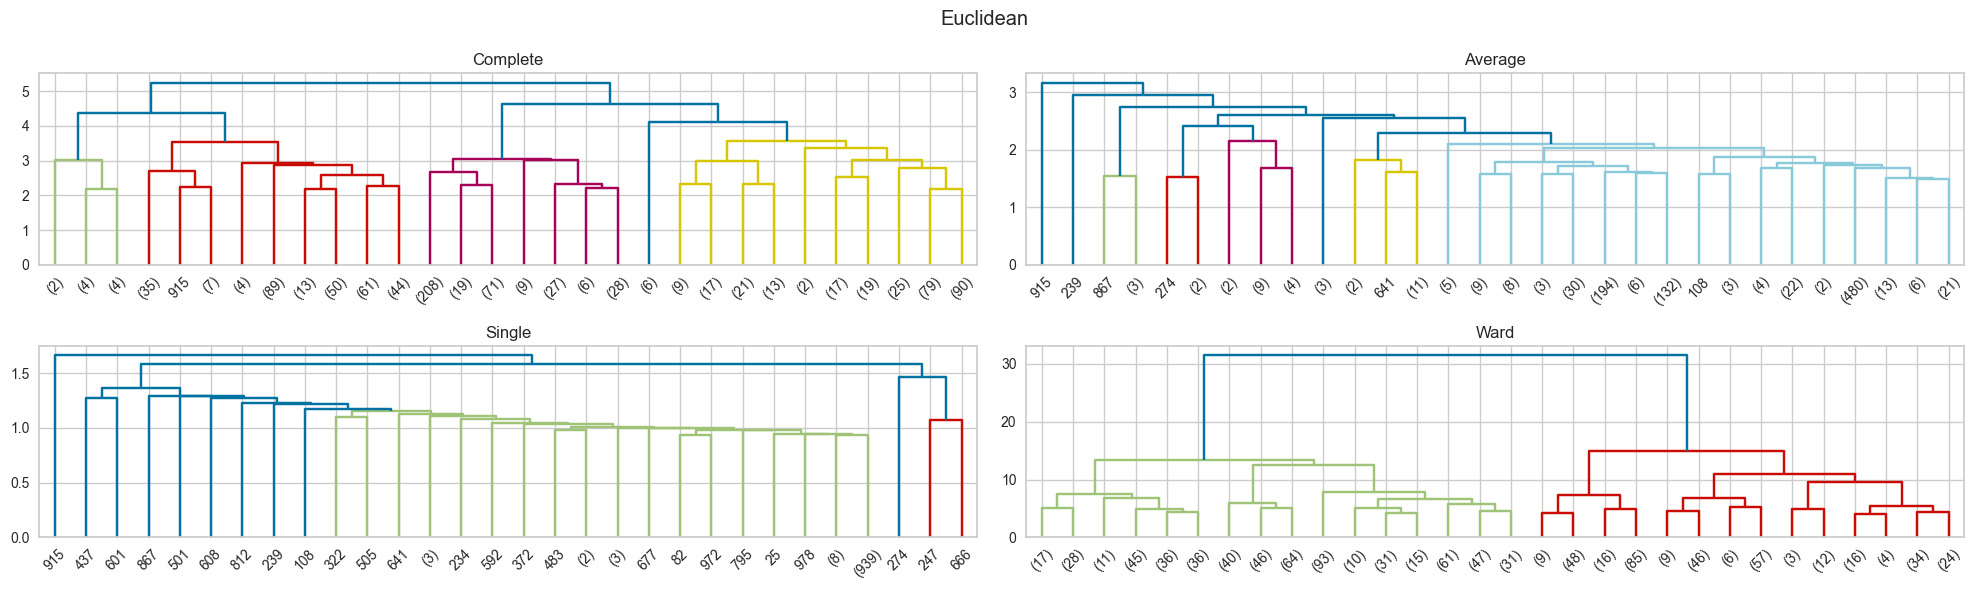

In [30]:
fig, axes = plt.subplots(2, 2,  figsize=(20,6))

mergings = linkage(df,method='complete',metric='euclidean')
dendrogram(mergings,truncate_mode='lastp',ax=axes[0,0])
axes[0,0].set_title('Complete')

mergings = linkage(df,method='average',metric='euclidean')
dendrogram(mergings,truncate_mode='lastp',ax=axes[0,1])
axes[0,1].set_title('Average')

mergings = linkage(df,method='single',metric='euclidean')
dendrogram(mergings,truncate_mode='lastp',ax=axes[1,0])
axes[1,0].set_title('Single')

mergings = linkage(df,method='ward',metric='euclidean')
dendrogram(mergings,truncate_mode='lastp',ax=axes[1,1])
axes[1,1].set_title('Ward')

fig.suptitle('Euclidean')
fig.tight_layout()
plt.show()

- As we can watch, automatically we drop the idea to continue with the 'single' and 'average' since they have lots of clusters that have been overlaped.
- So at first sight, the best option is the 'complete' because it has clearly 3 well structured clusters.  (The left supposed cluster only has 10 samples)

##### Cosine

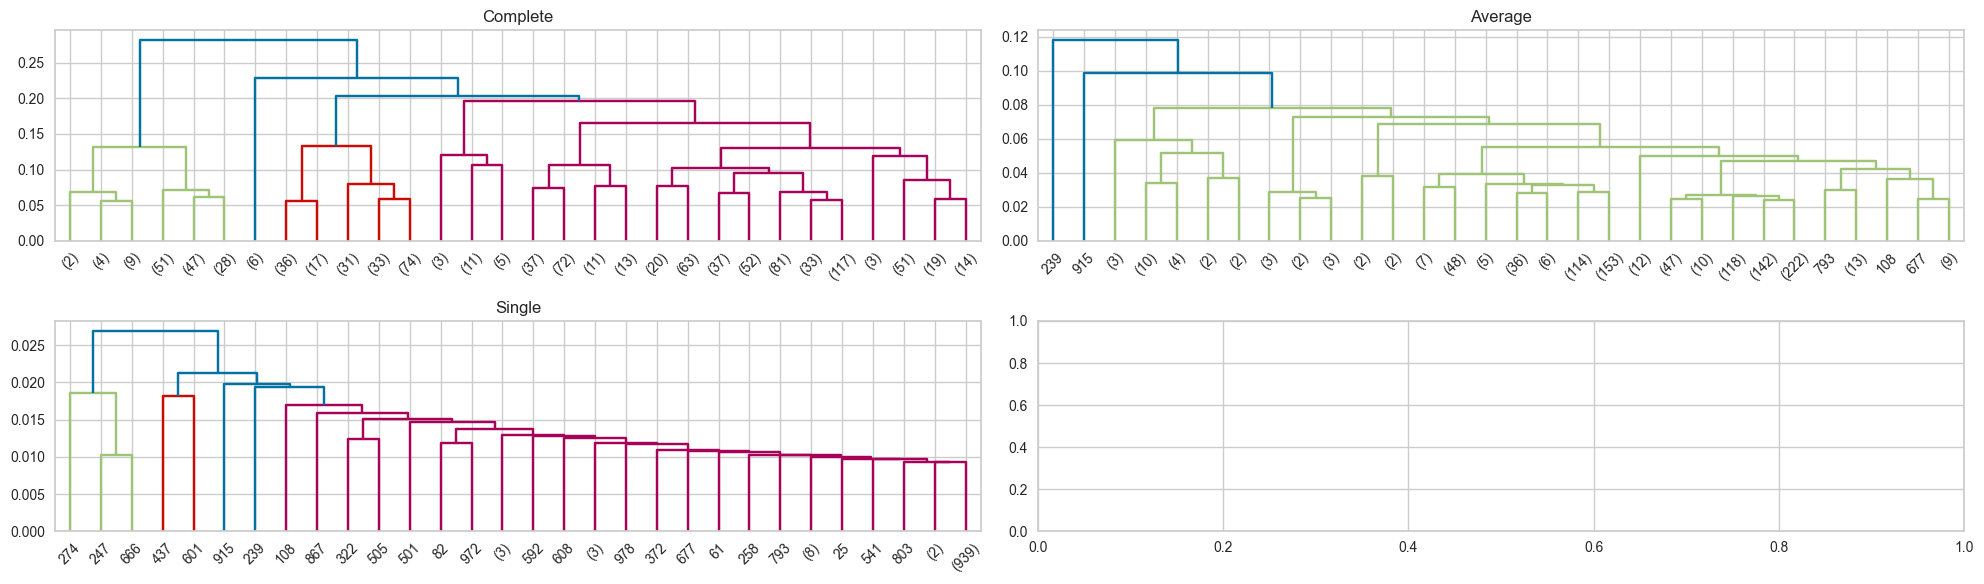

In [31]:
fig, axes = plt.subplots(2, 2,  figsize=(20,6))

mergings = linkage(df,method='complete',metric='cosine')
dendrogram(mergings,truncate_mode='lastp',ax=axes[0,0])
axes[0,0].set_title('Complete')

mergings = linkage(df,method='average',metric='cosine')
dendrogram(mergings,truncate_mode='lastp',ax=axes[0,1])
axes[0,1].set_title('Average')

mergings = linkage(df,method='single',metric='cosine')
dendrogram(mergings,truncate_mode='lastp',ax=axes[1,0])
axes[1,0].set_title('Single')

fig.tight_layout()
plt.show()

- Using 'cosine' provokes overlaping in the single method.
- And in the other average methods, there are considerable number of outliers

##### Manhattan

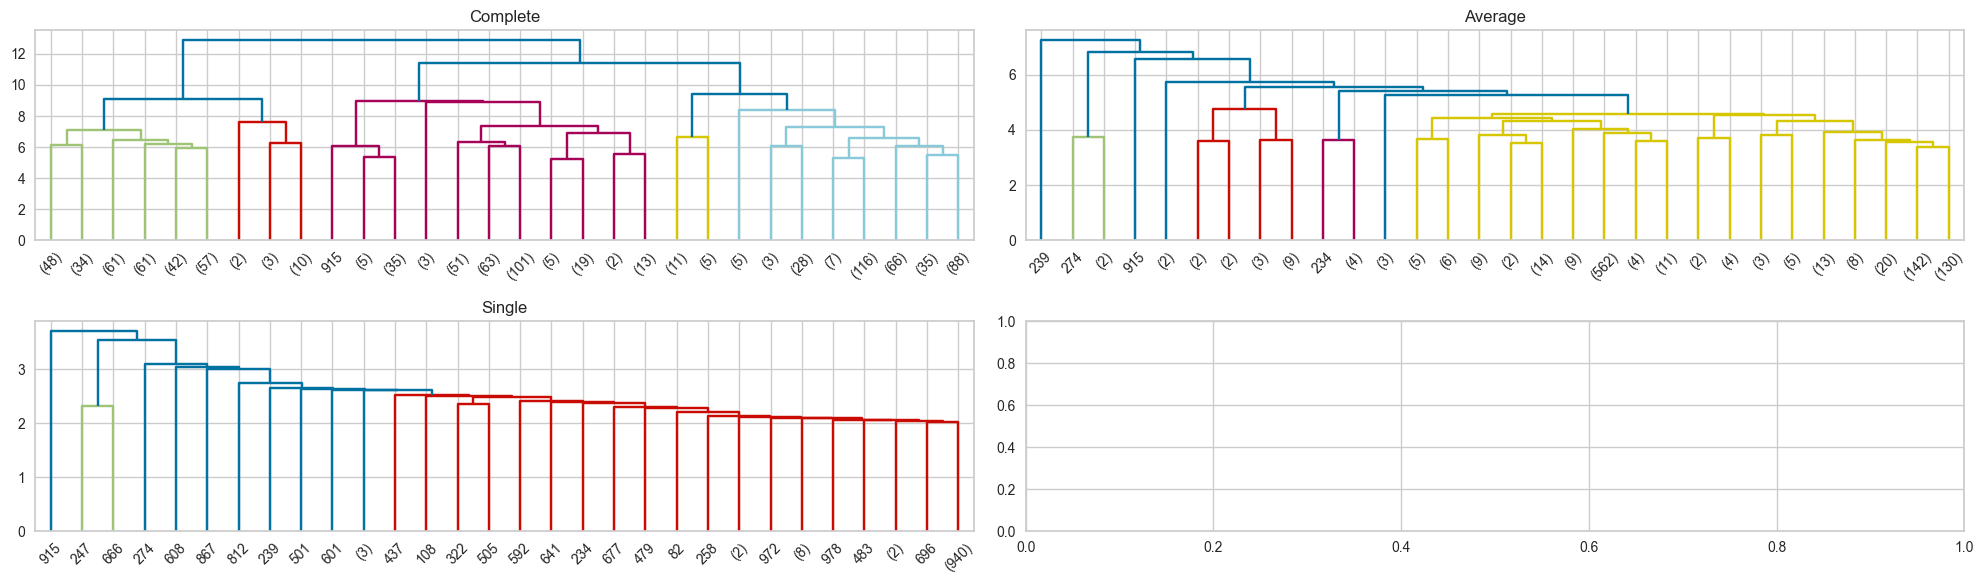

In [32]:
fig, axes = plt.subplots(2, 2,  figsize=(20,6))

mergings = linkage(df,method='complete',metric='cityblock')
dendrogram(mergings,truncate_mode='lastp',ax=axes[0,0])
axes[0,0].set_title('Complete')

mergings = linkage(df,method='average',metric='cityblock')
dendrogram(mergings,truncate_mode='lastp',ax=axes[0,1])
axes[0,1].set_title('Average')

mergings = linkage(df,method='single',metric='cityblock')
dendrogram(mergings,truncate_mode='lastp',ax=axes[1,0])
axes[1,0].set_title('Single')

fig.tight_layout()
plt.show()

- Also overlaping in 'single' and 'average'
- But there is an interesting clustring in the 'complete' method

# Task 6 – Dimensionality Reduction (PCA)

In [33]:
df_sc.cov()

,art_galleries,dance_clubs,juice_bars,restaurants,museums,resorts,parks,beaches,theaters,religious_institutions
art_galleries,1.001021,-0.187884,0.008621,0.073531,-0.100585,0.094238,-0.012487,0.020050,-0.047361,0.050752
dance_clubs,-0.187884,1.001021,0.043631,0.131758,0.119753,0.148555,0.110164,-0.158804,0.073417,-0.065829
juice_bars,0.008621,0.043631,1.001021,0.061190,0.281956,0.356799,0.751418,-0.173130,-0.085523,-0.440993
restaurants,0.073531,0.131758,0.061190,1.001021,0.101982,0.216087,0.228582,-0.103689,0.026697,-0.353270
museums,-0.100585,0.119753,0.281956,0.101982,1.001021,0.581900,0.232555,-0.020979,0.041736,-0.247723
resorts,0.094238,0.148555,0.356799,0.216087,0.581900,1.001021,0.431183,0.000071,0.096508,-0.438551
parks,-0.012487,0.110164,0.751418,0.228582,0.232555,0.431183,1.001021,-0.072566,0.085052,-0.711457
beaches,0.020050,-0.158804,-0.173130,-0.103689,-0.020979,0.000071,-0.072566,1.001021,0.169868,0.114818
theaters,-0.047361,0.073417,-0.085523,0.026697,0.041736,0.096508,0.085052,0.169868,1.001021,-0.045729
religious_institutions,0.050752,-0.065829,-0.440993,-0.353270,-0.247723,-0.438551,-0.711457,0.114818,-0.045729,1.001021


- All good, no zero and all are corelated

In [34]:
pca=PCA() 
pca_transformed=pca.fit_transform(df_sc)
df_pca=pd.DataFrame(pca_transformed, index=df_sc.index)
df_pca.round(2)

,0,1,2,3,4,5,6,7,8,9
0,2.41,-0.07,0.19,0.16,-0.84,0.92,0.41,-0.09,0.54,-0.54
1,5.31,-0.02,0.65,-0.03,-0.23,1.90,0.30,-0.13,0.49,1.18
2,-0.81,-1.78,-0.85,0.75,-0.65,-0.30,-0.16,-1.18,-0.01,-0.13
3,-1.07,0.86,0.96,0.13,-1.20,-0.78,0.95,-0.31,0.32,0.24
4,0.99,-0.08,0.74,-0.85,0.85,-1.40,-0.57,-0.21,-0.38,-0.23
...,...,...,...,...,...,...,...,...,...,...
975,-2.14,-0.79,0.81,-0.21,1.08,-1.04,-0.13,0.28,0.09,0.08
976,-0.50,-1.34,-0.81,-0.16,0.34,0.34,-0.16,-0.26,-0.18,-0.06
977,-1.06,0.46,0.78,-0.70,1.17,-0.68,-0.41,0.15,-0.06,-0.41
978,-2.20,-1.96,-1.42,-0.25,-1.71,-1.97,-0.18,-0.86,-1.38,0.14


[ 29.77504407  42.40298375  54.73397667  65.37868071  75.57687727
  83.65669366  90.7012403   95.30112707  98.58996912 100.        ]


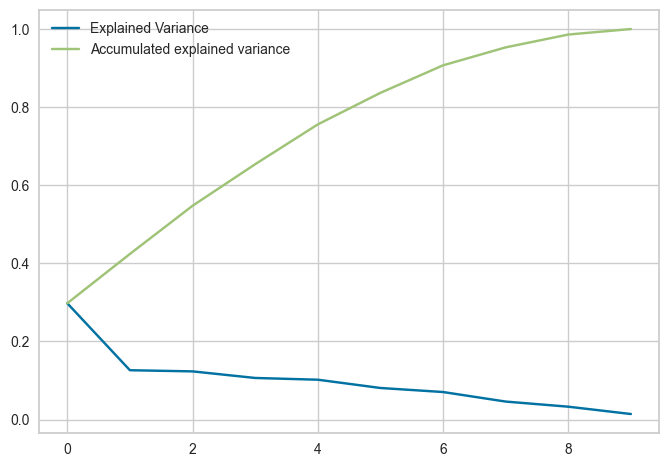

In [35]:
explained_variance = pca.explained_variance_ratio_
plt.plot(explained_variance,label='Explained Variance')
plt.plot(np.add.accumulate(explained_variance),label='Accumulated explained variance')
plt.legend()

print(np.add.accumulate(explained_variance*100))

- 83.65% of the variance is accounted for by the first 6 principal components. 
- A big share (42.4%) is held by the variance of the first two principal component. 
- So the question is to choose between 5 elements or 6 elements. With 6 elements you surpass the threshold of 80%, but decreasing by one you have a very good percentage of the variance with 75.57%, and you can reduce by a half the elements.
- So I am going to select five principal components to be retained.

In [36]:
pca_data = df_pca.iloc[:,:5]

##### PCA - KMeans

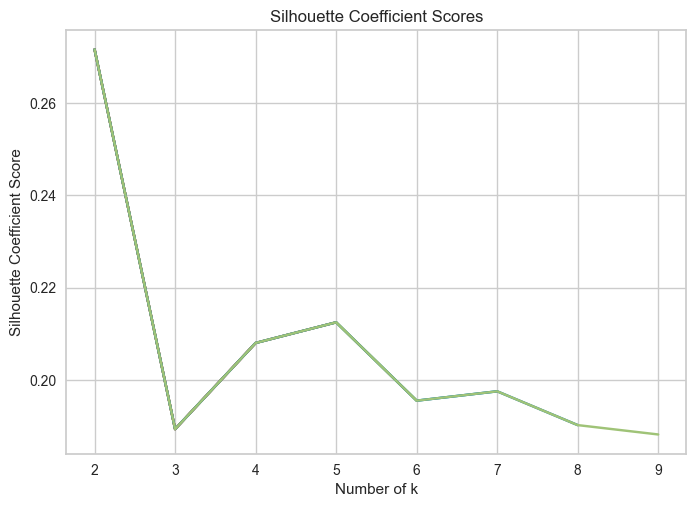

In [37]:
KMeansSihouettePlot(pca_data, 10)

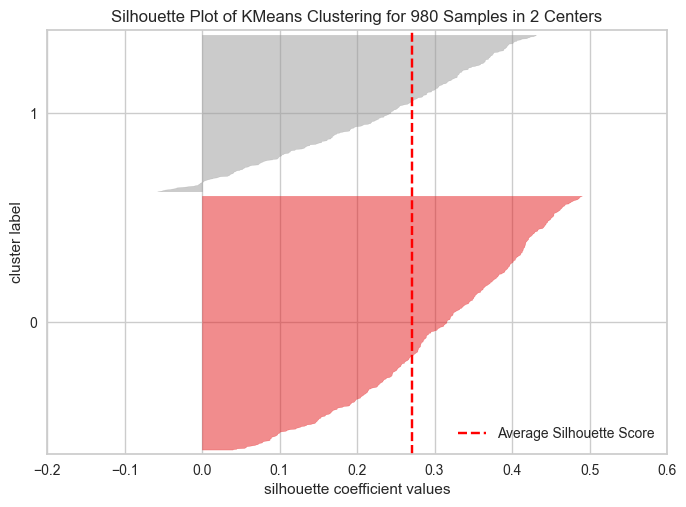

In [38]:
kmeans = getKMeans(k=2)
cluster_labels = kmeans.fit_predict(pca_data)
sihouetteVisualizer(pca_data, kmeans)

##### PCA - HCA

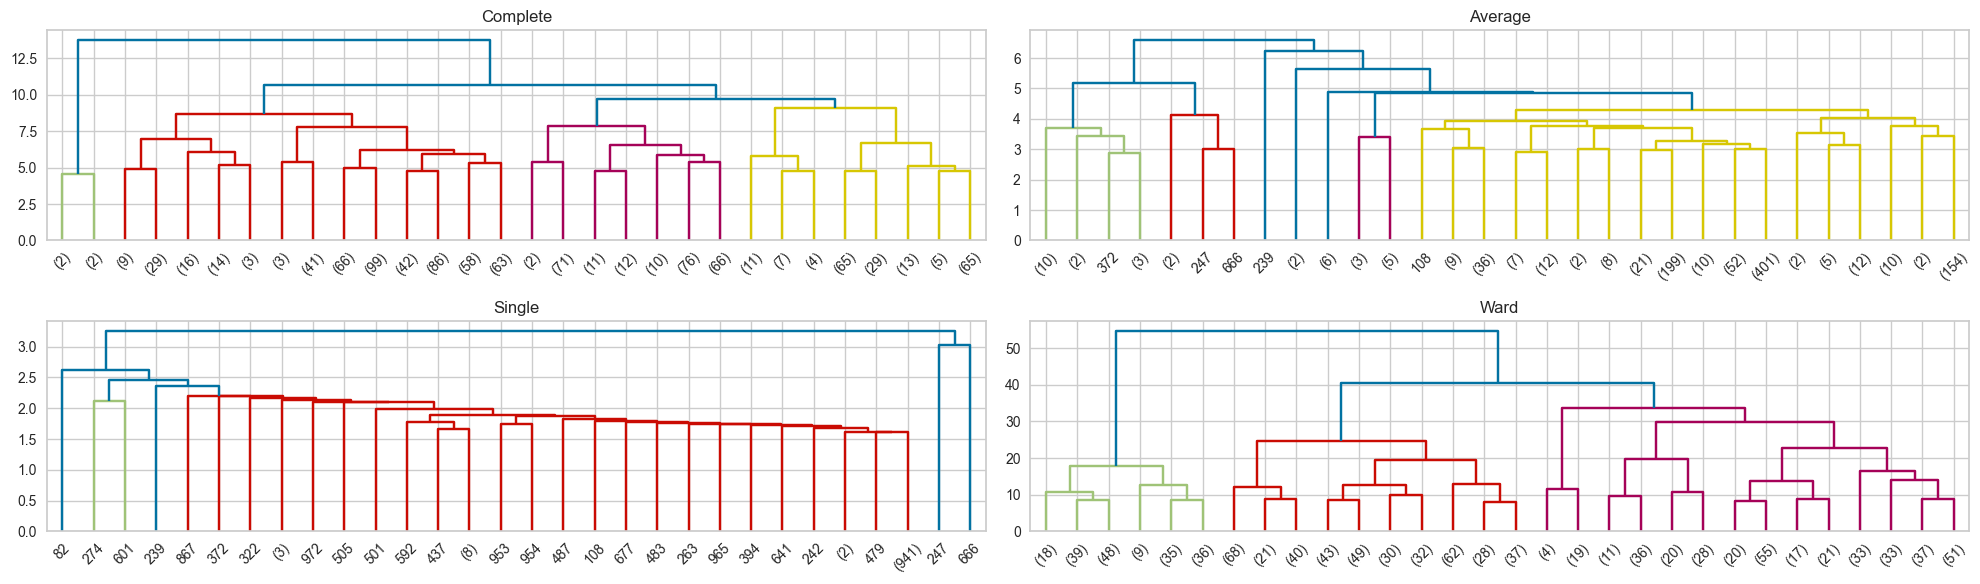

In [39]:
fig, axes = plt.subplots(2, 2,  figsize=(20,6))

mergings = linkage(pca_data,method='complete',metric='euclidean')
dendrogram(mergings,truncate_mode='lastp',ax=axes[0,0])
axes[0,0].set_title('Complete')

mergings = linkage(pca_data,method='average',metric='euclidean')
dendrogram(mergings,truncate_mode='lastp',ax=axes[0,1])
axes[0,1].set_title('Average')

mergings = linkage(pca_data,method='single',metric='euclidean')
dendrogram(mergings,truncate_mode='lastp',ax=axes[1,0])
axes[1,0].set_title('Single')

mergings = linkage(pca_data,method='ward',metric='euclidean')
dendrogram(mergings,truncate_mode='lastp',ax=axes[1,1])
axes[1,1].set_title('Ward')

fig.tight_layout()
plt.show()

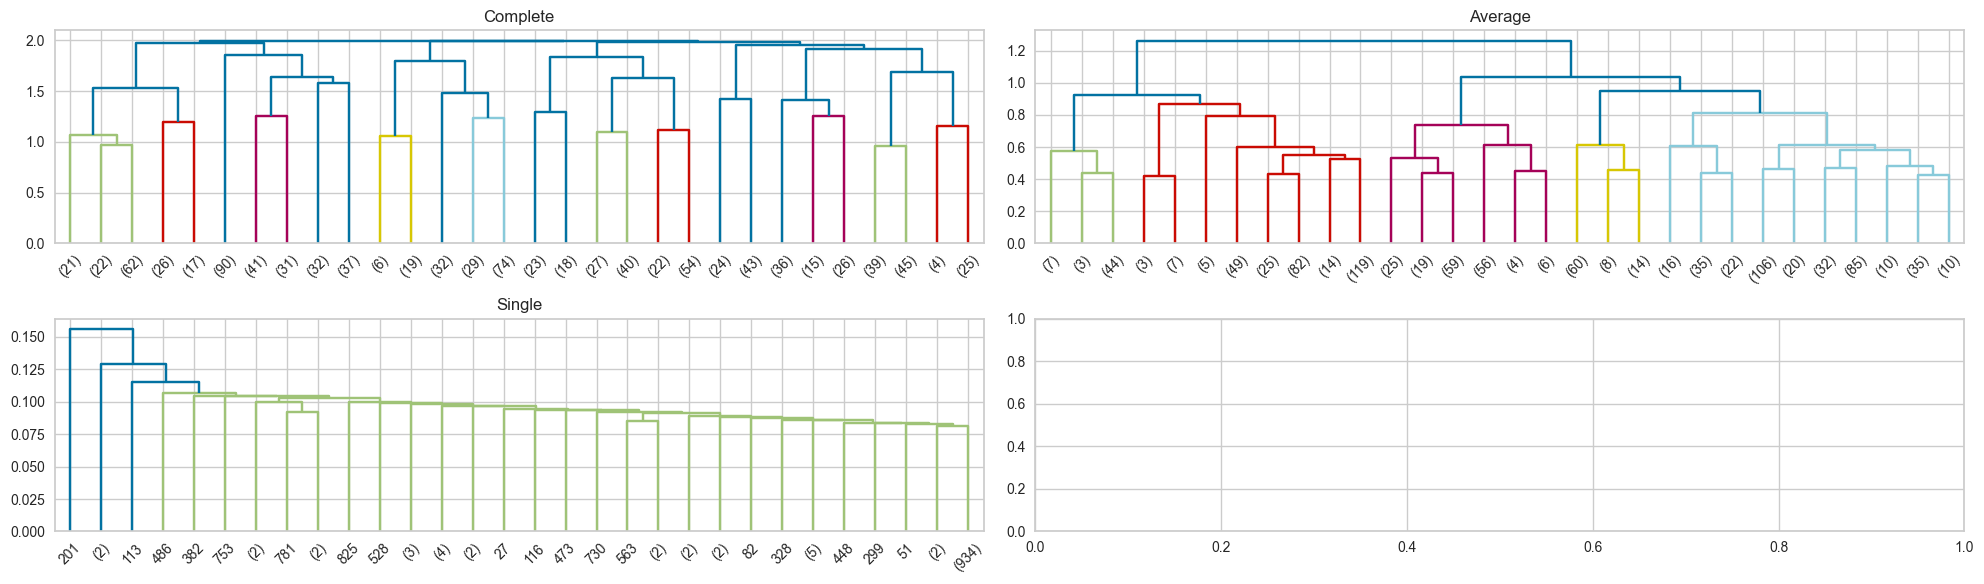

In [40]:
fig, axes = plt.subplots(2, 2,  figsize=(20,6))

mergings = linkage(pca_data,method='complete',metric='cosine')
dendrogram(mergings,truncate_mode='lastp',ax=axes[0,0])
axes[0,0].set_title('Complete')

mergings = linkage(pca_data,method='average',metric='cosine')
dendrogram(mergings,truncate_mode='lastp',ax=axes[0,1])
axes[0,1].set_title('Average')

mergings = linkage(pca_data,method='single',metric='cosine')
dendrogram(mergings,truncate_mode='lastp',ax=axes[1,0])
axes[1,0].set_title('Single')

fig.tight_layout()
plt.show()

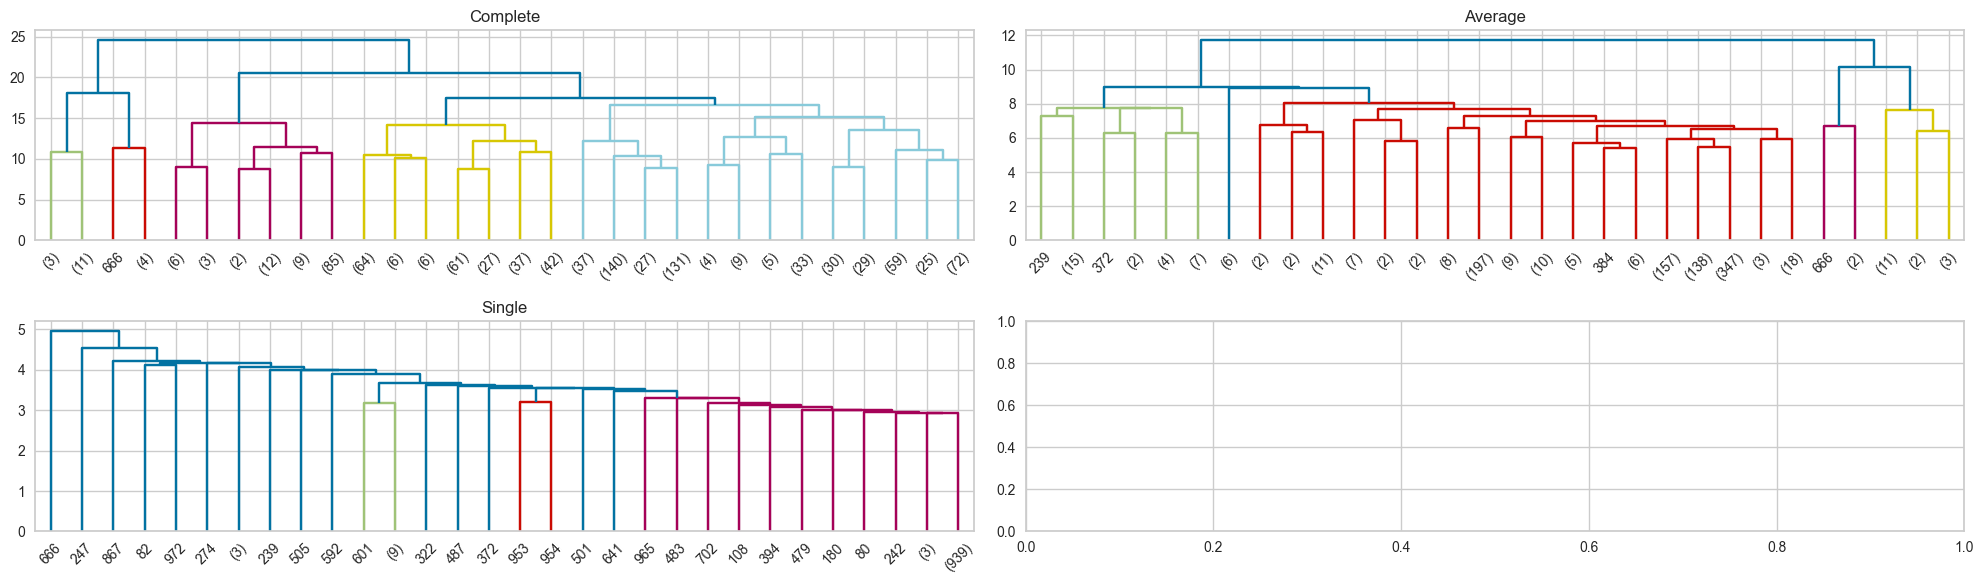

In [41]:
fig, axes = plt.subplots(2, 2,  figsize=(20,6))

mergings = linkage(pca_data,method='complete',metric='cityblock')
dendrogram(mergings,truncate_mode='lastp',ax=axes[0,0])
axes[0,0].set_title('Complete')

mergings = linkage(pca_data,method='average',metric='cityblock')
dendrogram(mergings,truncate_mode='lastp',ax=axes[0,1])
axes[0,1].set_title('Average')

mergings = linkage(pca_data,method='single',metric='cityblock')
dendrogram(mergings,truncate_mode='lastp',ax=axes[1,0])
axes[1,0].set_title('Single')

fig.tight_layout()
plt.show()

# Task 7 – Conclusions and Future Work


- Before applying the PCA to clustering these are the conclusions.
- I have choose the HAC with method complete and the distanced calculated by euclidean

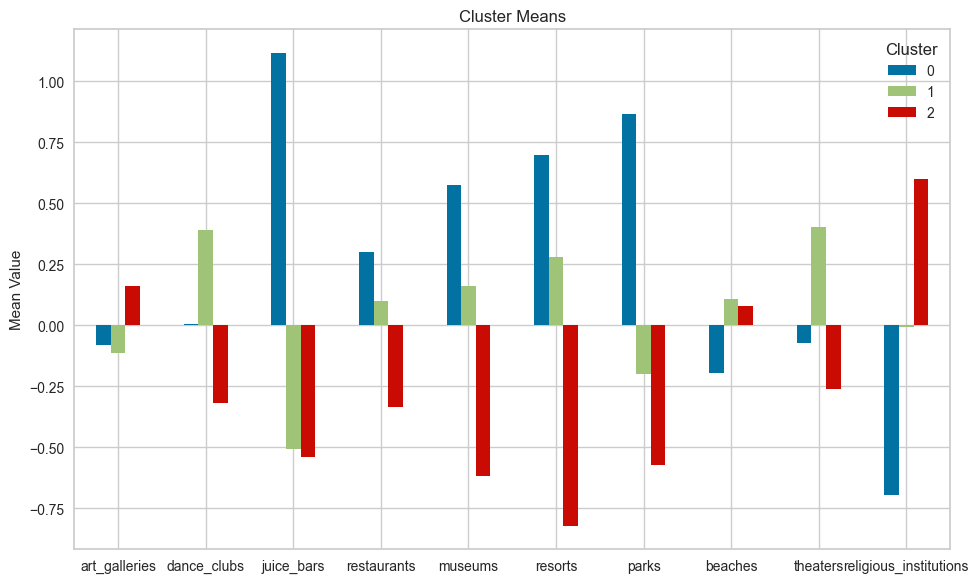

Cluster
2    368
0    314
1    298
Name: count, dtype: int64


In [42]:
# Apply the clustering hierarchical agglomerative algorithm to the df
agg_complete = cluster.AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='complete', compute_distances=True)
labels = agg_complete.fit_predict(df)

# Adding the information of cluster to the df
df_agg = df_sc.copy()
df_agg['Cluster']=labels
df_agg_means=df_agg.groupby('Cluster').mean()

#Plot
df_agg_means.T.plot(kind='bar', figsize=(10, 6))
plt.title('Cluster Means')
plt.ylabel('Mean Value')
plt.legend(title='Cluster')
plt.xticks(rotation=360)
plt.tight_layout()
plt.show()

#Number of samples in each cluster
print(df_agg.Cluster.value_counts())

#### Interpretation

##### Cluster 0 (Blue)
- High rating in museums, resorts, parks and beaches.
- Moderate interest in art galleries and dance clubs.
- Could represent tourists who prefer cultural and outdoor experiences, such as visiting museums and parks, over nightlife or food-related activities. Relaxed vacations.

##### Cluster 1 (Yellow)
- High rating in dance clubs, parks and beaches
- Moderate interest in resorts and restaurants
- It seems to represent visitors who enjoy social and recreational activities. The high interest in dance clubs indicates a preference for nightlife

##### Cluster 2 (Green)
- High rating at religious_museums.
- Lowest ratings in almost every other features. Except beaches and parks, where the nature is involved.
- Tourists that are focus on religious or spiritual purposes and are less interested in exploring general recreational and social sites.

#### Original Plan
- We wanted to group tourists with similar preferences so we are enable to create more personalized experiences and improving customer engagement. So thanks to the calculation we know that 3 profiles
- Cultural/Outdoor experiences, social/nighlife enjoyer and the spirituals.

#### Generated Value
- We have identified that the spiritual profile values a lot of the religious temples, but on other hand, it doesn't get interested or like the other categories.
- The nightlife profile is not very keen on going to the parks or beaches, it prefers to go to the theaters or resorts, to be more entertained.
- Cultural/Outdoor profile would be the average person that is interested on avergae in all the categories except for the religious institutions.

#### Course of action

- Develop specialized travel packages for each cluster, such as nightlife-centered and spiritual tours.
- Focus advertising efforts by channeling social media campaigns towards travelers fitting each profile, with visual content reflecting their cluster’s interests.
- Dynamic pricing by identifying peak interests and seasons for each cluster, allowing for more strategic pricing or bundles.

#### Limitations

- The reliance on East Asian destination preferences may not generalize well to other regions.
- The dataset captures only ten types of destinations
- Preferences and interests may evolve over time

#### Future work
- Obviously, we should apply the PCA on Phase III to see the evolution of the results of the algorithms.
- Making hypothesis tests to realize the significant features, so we can cluster them.

#### Reflect the original task
- The goals were achievable but could benefit from refinements, like including more features so we can support a richer set of clusters.